In [1]:
import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

from eda.models import Generation
from eda.parsing import Conversations, Participants

participants = Participants()
conversations = Conversations(participants)

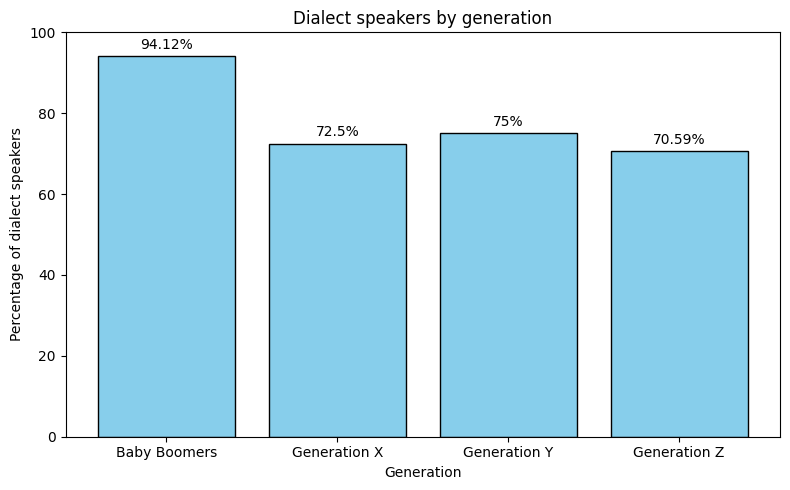

In [ ]:
from eda.models import Participant
from eda.utils import round_precise


def participant_speaks_dialect(participant: Participant) -> bool:
    return bool(conversations.participant_dialect_words(participant))


dialect_counts: dict[Generation, list[int]] = Generation.create_mapping()
for generation in dialect_counts:
    dialect_counts[generation].extend((0, 0))

for participant in participants:
    percentages = dialect_counts[participant.generation]
    percentages[0] += participant_speaks_dialect(participant)
    percentages[1] += 1

generation_names = []
percentages = []
for generation, (speaker_count, participant_count) in dialect_counts.items():
    percentage = round_precise(speaker_count / participant_count * 100, 2)
    generation_names.append(generation.name)
    percentages.append(percentage)

plt.figure(figsize=(8, 5))
plt.bar(generation_names, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Generation")
plt.ylabel("Percentage of dialect speakers")
plt.title("Dialect speakers by generation")
plt.ylim(0, 100)

for i, value in enumerate(percentages):
    plt.text(i, value + 1, f"{value}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [3]:
conversations.read_all()

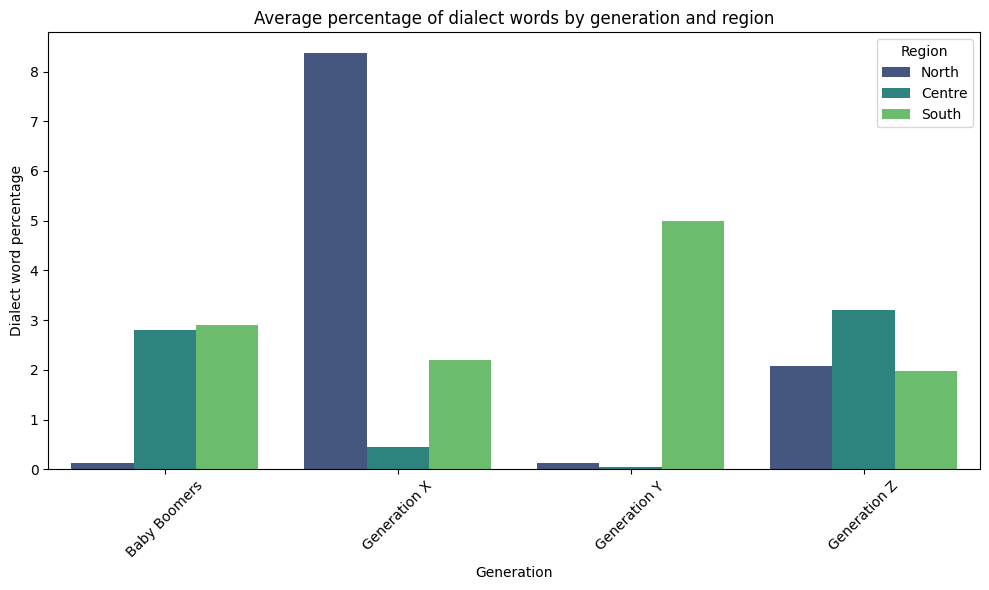

In [14]:
from collections.abc import Callable, Generator

import pandas as pd
import seaborn as sns

from eda.language import AttributedWord
from eda.models import MacroRegion, ParticipantLines


def participant_macro_region(participant: Participant) -> MacroRegion:
    conversation = conversations.conversation(participant.conversation_code)
    return conversation.macro_region


def generate_participant_words(lines: ParticipantLines) -> Generator[AttributedWord]:
    for line in lines:
        yield from filter(lambda word: word.is_linguistic, line.normalised_words)


def participant_dialect_percentages(
    *, rounder: Callable[[int | float, int], int | float] = round_precise
) -> list[int | float]:
    percentages = []

    for participant in participants:
        participant_lines = conversations.participant_lines(participant)
        dialect_words = total_words = 0
        for word in generate_participant_words(participant_lines):
            dialect_words += word.is_dialect(strict=False)
            total_words += 1

        percentange_of_dialect_words = rounder(dialect_words / total_words * 100, 2)
        percentages.append(percentange_of_dialect_words)

    return percentages


percentages = participant_dialect_percentages()
generations = [participant.generation.name for participant in participants]
macro_regions = [
    participant_macro_region(participant).name.capitalize()
    for participant in participants
]

df = pd.DataFrame({
    "dialect_percentage": percentages,
    "generation": generations,
    "region": macro_regions,
})

grouped = (
    df.groupby(["generation", "region"], observed=True)
    .agg(
        dialect_percentage=("dialect_percentage", "mean"),
        n_speakers=("dialect_percentage", "count"),
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=grouped,
    x="generation",
    y="dialect_percentage",
    hue="region",
    hue_order=["North", "Centre", "South"],
    palette="viridis",
)

plt.title("Average percentage of dialect words by generation and region")
plt.ylabel("Dialect word percentage")
plt.xlabel("Generation")
plt.legend(title="Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()